In [1]:
import torch
import torchvision.transforms as transforms
import torch.utils.data
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import pprint
from DataSet import MyDataSet
import pandas as pd
import Net
import matplotlib.pyplot as plt
import torchvision
import torchvision.io as io
import multiprocessing
from multiprocessing import Pool
from multiprocessing import Process
from pathlib import Path
import cv2

C:\Users\moko0\OneDrive\ドキュメント\repos\SyuraiRinjin\TrainData2\Photo\RGB\10.png


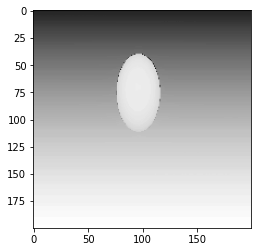

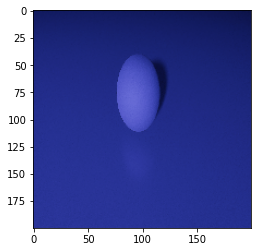

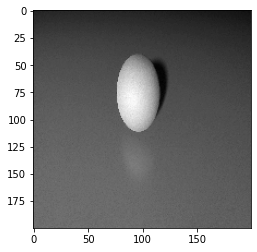

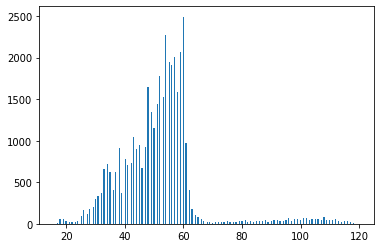

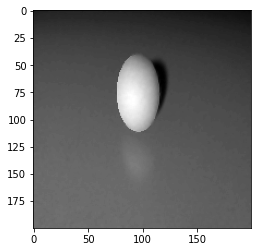

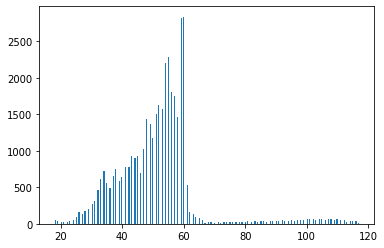

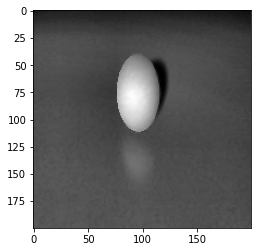

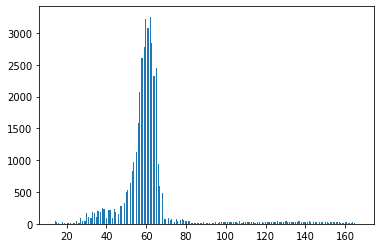

In [2]:
RGBimagePaths = [str(p) for p in Path("C:/Users/moko0/OneDrive/ドキュメント/repos/SyuraiRinjin/TrainData2/Photo/RGB/").glob("*.png")]
DepthImagePaths = [str(p) for p in Path("C:/Users/moko0/OneDrive/ドキュメント/repos/SyuraiRinjin/TrainData2/Photo/Depth/").glob("*.png")]

#前処理の宣言
transform = nn.Sequential(
    #transforms.ToPILImage(),
    transforms.Resize((200, 200)),
    #transforms.ToTensor(),
    #transforms.ConvertImageDtype(torch.float32),
    #transforms.Normalize(0.5, 0.5),
).cuda()

print(RGBimagePaths[1])
path = "dataSet/raw_image/spice.jpg"
RGBimage = io.read_image(path=RGBimagePaths[0], mode=io.image.ImageReadMode.RGB)
GrayImage = io.read_image(path=RGBimagePaths[0], mode=io.image.ImageReadMode.GRAY)
DepthImage = io.read_image(path=DepthImagePaths[0], mode=io.image.ImageReadMode.GRAY)

RGBimage = transform(RGBimage)
GrayImage = transform(GrayImage)
DepthImage = transform(DepthImage)
RGBimage = np.transpose(RGBimage.numpy(), (1, 2, 0))
GrayImage = np.transpose(GrayImage.numpy(), (1, 2, 0))
DepthImage = np.transpose(DepthImage.numpy(), (1, 2, 0))

after = GrayImage
after = cv2.cv2.ximgproc.dtFilter(GrayImage, GrayImage, 0, 32)

bilateral = after

#after = cv2.bilateralFilter(after, 5, sigmaColor=20, sigmaSpace=20)
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(4,4))
after = clahe.apply(after)



#after = after / 256.0
#after = cv2.equalizeHist(after)

#ret, after = cv2.threshold(after, 0, 255, cv2.THRESH_OTSU)
#kernel = np.ones((3,3), np.uint8)
#after = cv2.morphologyEx(after, cv2.MORPH_CLOSE, kernel, iterations=1)

#rgb_npimg = np.squeeze(rgb_npimg, 0)
#rgb_npimg = (rgb_npimg + 1.0) / 2.0
plt.imshow(DepthImage, cmap="gray")
plt.show()
plt.imshow(RGBimage, cmap="gray")
plt.show()
plt.imshow(GrayImage, cmap="gray")
plt.show()
plt.hist(GrayImage.ravel(), bins=256)
plt.show()
plt.imshow(bilateral, cmap="gray")
plt.show()
plt.hist(bilateral.ravel(), bins=256)
plt.show()
plt.imshow(after, cmap="gray")
plt.show()
plt.hist(after.ravel(), bins=256)
plt.show()


In [ ]:
RGBimagePaths = [str(p) for p in Path("C:/Users/moko0/OneDrive/ドキュメント/repos/SyuraiRinjin/TrainData2/Photo/RGB/").glob("*.png")]

#前処理の宣言
transform = nn.Sequential(
    #transforms.ToPILImage(),
    transforms.Resize((200, 200)),
    #transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(0.5, 0.5),
).cuda()

print(RGBimagePaths[0])
RGBimage = io.read_image(path=RGBimagePaths[0], mode=io.image.ImageReadMode.RGB)
GrayImage = io.read_image(path=RGBimagePaths[0], mode=io.image.ImageReadMode.GRAY)

RGBimage = np.transpose(RGBimage.numpy(), (1, 2, 0))
GrayImage = transform(GrayImage)
GrayImage = np.transpose((GrayImage.numpy() + 1) / 2 * 256, (1, 2, 0))

after = GrayImage
after = cv2.bilateralFilter(after, 5, sigmaColor=20, sigmaSpace=20)
bilateral = after
after = cv2.equalizeHist(after.astype(np.uint8))
#clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
#after = clahe.apply(after.astype(np.uint8))

ret, nichi = cv2.threshold(after, 0, 255, cv2.THRESH_OTSU)

#rgb_npimg = np.squeeze(rgb_npimg, 0)
#rgb_npimg = (rgb_npimg + 1.0) / 2.0
plt.imshow(RGBimage)
plt.show()
plt.imshow(GrayImage, cmap="gray")
plt.show()
plt.imshow(bilateral, cmap="gray")
plt.show()
plt.imshow(after, cmap="gray")
plt.show()
plt.imshow(nichi, cmap="gray")
plt.show()
plt.hist(GrayImage.ravel(), bins=256)
plt.show()
plt.hist(after.ravel(), bins=256)
plt.show()
plt.hist(nichi.ravel(), bins=256)
plt.show()

In [ ]:
import torch
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import pprint
from DataSet import MyDataSet
import pandas as pd
import Net
import matplotlib.pyplot as plt
import torchvision
import torchvision.io as io
import multiprocessing
from multiprocessing import Pool
from multiprocessing import Process
from pathlib import Path
import MySampler

#学習率スケジューラ
class LearningRateScheduler:
    def __init__(self, base_lr: float, max_epoch: int, power=0.9):
        self.max_epoch = max_epoch
        self.base_lr = base_lr
        self.power = power

    def __call__(self, epoch: int):
        if epoch <= 5:
            return self.base_lr * (epoch + 1) / 5
        return (1 - max(epoch - 6, 1) / self.max_epoch) ** self.power * self.base_lr

#############
###~~訓練~~###
##############
#model.train()
#scaler = torch.cuda.amp.GradScaler()

def loop():
    #データセットの定義
    dataSet = MyDataSet(imageSize=200)

    data_size = len(dataSet)
    train_size = int(data_size * 0.8)
    val_size = int(data_size * 0.1)
    test_size = data_size - train_size - val_size

    """
    train_indices = list(range(0, train_size))
    val_indices = list(range(train_size, data_size + val_size))
    test_indices = list(range(train_size + val_size, data_size))

    train_dataset = Subset(dataSet, train_indices)
    val_dataset = Subset(dataSet, val_indices)
    test_dataset = Subset(dataSet, test_indices)
    """

    dataLoader = DataLoader(dataset=dataSet, batch_size=1, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

    #学習の準備
    model = Net.MyResNet50(1)           #モデルの読み込み
    model = model.cuda()
    criterion = nn.MSELoss()            #損失関数は平均2乗誤差
    torch.backends.cudnn.benchmark = True

    epoch = 200
    lr = 1e-3
    lr_scheduler = LearningRateScheduler(lr, epoch)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler)
    scaler = torch.cuda.amp.GradScaler()

    i = 0
    for (RGBimage, DepthImage, x, y, z) in dataLoader:
        if i < 3 or i == 14313 or i == 14314 or i == 23110:
            rgb_npimg = RGBimage.numpy()
            depth_npimg = DepthImage.numpy()
            rgb_npimg = np.squeeze(rgb_npimg, 0)
            depth_npimg = np.squeeze(depth_npimg, 0)

            rgb_npimg = (rgb_npimg + 1.0) / 2.0
            depth_npimg = (depth_npimg + 1.0) / 2.0
            plt.imshow(np.transpose(rgb_npimg, (1, 2, 0)))
            plt.show()
            plt.imshow(np.transpose(depth_npimg, (1, 2, 0)))
            plt.show()

            print("i=" + str(i))
            print("x=" + str(x))
            print("y=" + str(y))

        i += 1


if __name__ == "__main__":
    loop()

In [ ]:
#データセットの定義
dataSet = MyDataSet(imageSize=200)

data_size = len(dataSet)
train_size = int(data_size * 0.8)
val_size = int(data_size * 0.1)
test_size = data_size - train_size - val_size

"""
train_indices = list(range(0, train_size))
val_indices = list(range(train_size, data_size + val_size))
test_indices = list(range(train_size + val_size, data_size))

train_dataset = Subset(dataSet, train_indices)
val_dataset = Subset(dataSet, val_indices)
test_dataset = Subset(dataSet, test_indices)
"""

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataSet, (train_size, val_size, test_size))

#データローダーの定義
batchSize = 64
print("cpu_count:" + str(os.cpu_count()))
#sampler = MySampler.MySampler(batch_size=batchSize, shuffle=True, sampler=train_dataset)
trainLoader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True,num_workers = os.cpu_count(), pin_memory = True)
valLoader = DataLoader(val_dataset, batch_size= 1, shuffle=False, num_workers = os.cpu_count(), pin_memory = True)
testLoader = DataLoader(test_dataset, batch_size= 1, shuffle=False, num_workers = os.cpu_count(), pin_memory = True)

#学習の準備
model = Net.MyResNet50(1)           #モデルの読み込み
model = model.cuda()
criterion = nn.MSELoss()            #損失関数は平均2乗誤差
torch.backends.cudnn.benchmark = True

In [ ]:
"""
i = 0
for(RGBimage, DepthImage, x, y, z) in trainLoader:
    print(RGBimage.shape)
    print(DepthImage.shape)

    #RGBimage = RGBimage.view(RGBimage.shape[2], RGBimage.shape[0], RGBimage.shape[1])
    rgb_npimg = RGBimage.numpy()
    depth_npimg = DepthImage.numpy()
    print(rgb_npimg.shape)
    #print(npimg.shape)
    rgb_npimg = np.squeeze(rgb_npimg, 0)
    depth_npimg = np.squeeze(depth_npimg, 0)

    rgb_npimg = (rgb_npimg + 1.0) / 2.0
    depth_npimg = (depth_npimg + 1.0) / 2.0
    plt.imshow(np.transpose(rgb_npimg, (1, 2, 0)))
    plt.show()
    plt.imshow(np.transpose(depth_npimg, (1, 2, 0)))
    plt.show()

    if i == 10:
        break
    else:
        i += 1
    #print(np.transpose(npimg, (1, 2, 0)))
    #RGBimage = RGBimage.view(RGBimage.shape[1], RGBimage.shape[2], RGBimage.shape[0])
    #plt.imshow(DepthImage)
"""

In [ ]:
#学習率スケジューラ
class LearningRateScheduler:
    def __init__(self, base_lr: float, max_epoch: int, power=0.9):
        self.max_epoch = max_epoch
        self.base_lr = base_lr
        self.power = power

    def __call__(self, epoch: int):
        if epoch <= 5:
            return self.base_lr * (epoch + 1) / 5
        return (1 - max(epoch - 6, 1) / self.max_epoch) ** self.power * self.base_lr

In [ ]:
#############
###~~訓練~~###
##############
#model.train()
#scaler = torch.cuda.amp.GradScaler()

epoch = 200
lr = 1e-3
lr_scheduler = LearningRateScheduler(lr, epoch)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler)
scaler = torch.cuda.amp.GradScaler()

writer = SummaryWriter(log_dir="./logs/epoch200-4")

for i in range(epoch):
    model.train()
    test_loss = 0
    torch.set_grad_enabled(True)
    step = 0

    for(RGBimage, DepthImage, x, y, z) in trainLoader:
        #訓練データの初期化
        RGBimage = RGBimage.cuda()      
        DepthImage = DepthImage.cuda()
        x = x.cuda()
        y = y.cuda()
        z = z.cuda()     

        #勾配の初期化       
        optimizer.zero_grad()  
        print("initialized")

        #混合精度計算部
        with torch.cuda.amp.autocast():
            #学習
            #with torch.cuda.amp.autocast():
            out_x, out_y, out_z = model(RGBimage, DepthImage) 
            x = x.unsqueeze(1)
            y = y.unsqueeze(1)
            z = z.unsqueeze(1)

            loss_x = criterion(out_x.float(), x.float())
            loss_y = criterion(out_y.float(), y.float())
            loss_z = criterion(out_z.float(), z.float())
        
        print("AMP Clear")

        #3つの損失を適当な重みをかけて束ねる
        loss = (loss_x + loss_y + loss_z) / 3.0    
        test_loss += loss
        #loss = loss.float()

        print(step)
        step += 1
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        #loss.backward()
        #optimizer.step()
        scaler.update()
        print("update Clear")

        del loss_x, loss_y, loss_z, RGBimage, DepthImage, x, y, z, loss
    
    test_loss /= test_size
    writer.add_scalars("losses", { "loss_size200_lr1e-3_batch64_pow09": test_loss, } , i)
    #writer.add_histogram("fc_x.weights", model.fc_x.weight, i)
    #writer.add_histogram("fc_y.weights", model.fc_y.weight, i)
    #writer.add_histogram("fc_z.weights", model.fc_z.weight, i)
    del test_loss

    #バリデーションロス計算
    model.eval()
    loss = 0
    val_step = 1
    torch.set_grad_enabled(False)
    for (RGBimage, DepthImage, x, y, z) in valLoader:
        print("ValStep:" + str(val_step) + " / " + str(val_size))
        val_step += 1
        RGBimage = RGBimage.cuda()
        DepthImage = DepthImage.cuda()
        x = x.cuda()
        y = y.cuda()
        z = z.cuda()     

        out_x, out_y, out_z = model(RGBimage, DepthImage) 
        x = x.unsqueeze(1)
        y = y.unsqueeze(1)
        z = z.unsqueeze(1)

        loss_x = criterion(out_x.float(), x.float())
        loss_y = criterion(out_y.float(), y.float())
        loss_z = criterion(out_z.float(), z.float())

        #3つの損失を適当な重みをかけて束ねる
        loss += (loss_x + loss_y + loss_z) / 3.0

        del loss_x, loss_y, loss_z, RGBimage, DepthImage, x, y, z

    loss /= val_size

    writer.add_scalars("losses", {"val-loss_size200_lr1e-3_batch64_pow09": loss,} ,
                                    i)
    writer.add_scalar("Lerning Rate", np.array(scheduler.get_lr()), i)
    print("lr=" + str(scheduler.get_lr()))

    print("epoch: " + str(i + 1) + " / " + str(epoch))

    """
        学習率スケジューラ
    """
    scheduler.step()

torch.save(model.to("cpu").state_dict(), os.getcwd() + "/epoch200_size200_lr1e-3__batch64_pow09.pth")

In [ ]:
torchvision.get_image_backend()

In [ ]:
model = Net.MyResNet50(1)
model = model.cuda()
model.load_state_dict(torch.load("lightPos.pth"))

In [ ]:
torch.save(model.to("cpu").state_dict(), os.getcwd() + "/lightPosCPU.pth")

In [ ]:
#model = Net.MyResNet50(1)
#model.load_state_dict(torch.load("001-ep100", map_location=torch.device("cpu")))
model.to("cpu")
i = 0
dist = 0
ave_dist = 0
step = 0

#print(model.state_dict().keys())


for(RGBimage, DepthImage, x, y, z) in trainLoader:
    #初期化
    i += 1
    if i > 100:
        break

    print(RGBimage.shape)
    print(DepthImage.shape)

    """
    if i >= 1:
        #RGBimage = RGBimage.view(RGBimage.shape[2], RGBimage.shape[0], RGBimage.shape[1])
        rgb_npimg = RGBimage.numpy()
        depth_npimg = DepthImage.numpy()
        print(rgb_npimg.shape)
        #print(npimg.shape)
        rgb_npimg = np.squeeze(rgb_npimg, 0)
        depth_npimg = np.squeeze(depth_npimg, 0)

        rgb_npimg = (rgb_npimg + 1.0) / 2.0
        depth_npimg = (depth_npimg + 1.0) / 2.0
        plt.imshow(np.transpose(rgb_npimg, (1, 2, 0)))
        plt.show()
        plt.imshow(np.transpose(depth_npimg, (1, 2, 0)))
        plt.show()
        #print(np.transpose(npimg, (1, 2, 0)))
        #RGBimage = RGBimage.view(RGBimage.shape[1], RGBimage.shape[2], RGBimage.shape[0])
        #plt.imshow(DepthImage)
    """

    #テスト
    out_x, out_y, out_z = model(RGBimage, DepthImage)
    x = x.unsqueeze(1)
    y = y.unsqueeze(1)
    z = z.unsqueeze(1)

    loss_x = criterion(out_x.float(), x.float())
    loss_y = criterion(out_y.float(), y.float())
    loss_z = criterion(out_z.float(), z.float())

    loss = (loss_x + loss_y + loss_z) / 3.0

    #TensorBoard書き込み
    writer.add_scalars("Validation Losses", {  "loss": loss, 
                                    "loss_x": loss_x,
                                    "loss_y": loss_y,
                                    "loss_z": loss_z}
                                    , step)
    step += 1
    writer.close()

    #正解座標との距離
    dist = torch.sqrt((x - out_x) ** 2 + (y - out_y) ** 2 + (z - out_z) ** 2)
    #print("dist: " + str(dist))
    #"x[" + str(i) + "]: " + str(x) + "\n
    #print("out_x[" + str(i) + "]: " + str(out_x))
    print("out_x[" + str(i) + "]: " + str(out_x))
    print("out_y[" + str(i) + "]: " + str(out_y))
    print("out_z[" + str(i) + "]: " + str(out_z))
    ave_dist += dist

print("ave_dist: " + str(ave_dist / i))

In [ ]:

model = Net.MyResNet50(1)
model = model.cuda()
model.load_state_dict(torch.load("lightPos.pth"))
